In this notebook I will be implementing a transformer based Question Answering Model trained on SQuAD2.0

3/3/2021

### Introduction

To do

### Preparing the Data

In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim

import torchtext
print(torchtext.__version__)
from torchtext.datasets import SQuAD2

#tokenizer
from torchtext.data.utils import get_tokenizer
#from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

1.5.0+cpu
0.6.0


ImportError: cannot import name 'SQuAD2' from 'torchtext.datasets' (/usr/local/lib/python3.7/site-packages/torchtext/datasets/__init__.py)

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
tokenizer = get_tokenizer("spacy")

In [14]:
# obtain data and vocab with a custom tokenizer
train, dev = SQuAD2()

In [16]:
train.build_vocab(train, min_freq=2)

AttributeError: 

In [4]:
# tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use batch_first = True.

In [6]:
SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

In [7]:
# load data
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                        fields = (SRC, TRG))

In [8]:
# build vocab
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an encoder and a decoder, with the encoder encoding the input/source sentence (in German) into context vector and the decoder then decoding this context vector to output our output/target sentence (in English).

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

<img src="images/transformer-encoder.png">

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a positional embedding layer. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the <sos> (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out this section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, hid_dim. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

**The combined embeddings are then passed through $N$ encoder layers to get $Z$, which is then output and can be used by the decoder.**

The source mask, src_mask, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a <pad> token and 0 when it is a <pad> token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to <pad> tokens, which contain no useful information.

In [11]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim, 
                 hid_dim,
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super(Encoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                n_heads,
                                                pf_dim,
                                                dropout, 
                                                device)
                                   for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        # done with embeddings before encoder layers (real stuff)r
        for layer in self.layers:
            src = layer(src, src_mask)
        
        #src = [batch size, src len, hid dim]
        
        return src        

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the multi-head attention layer, then perform dropout on it, apply a residual connection and pass it through a Layer Normalization layer. We then pass it through a position-wise feedforward layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers.

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it self attention.

This article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim,
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super(EncoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]
        
        
        #self_attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connect and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual, and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src        

### Multi Head Attention Layer
One of the key, novel concepts introduced by the Transformer paper is the multi-head attention layer.

<img src="images/transformer-attention.png">

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self,
                 hid_dim, 
                 n_heads,
                 dropout, 
                 device):
        super(MultiHeadAttentionLayer, self).__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads #to scale by the square root of head_dim
        
        # head(i) = Attention(QW(i)^Q, KW(i)^K, VW(i)^V)
        # (i) = subscript = layer i
        # different head at every i (layer) 
        #         i.e q has n_head heads
        #             k has n_head heads
        #             v has n_head heads
        self.fc_q = nn.Linear(hid_dim, hid_dim) #QW^Q
        self.fc_k = nn.Linear(hid_dim, hid_dim) #KW^K
        self.fc_v = nn.Linear(hid_dim, hid_dim) #VW^V
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        
        #split the hid_dim of the query, key and value into n_heads
        #permute them so they can be multiplied together
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        
        #---doing scale dot product---
        # step 1: calculate the energy
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #[..., query len, head_dim] * [..., head_dim, key len] = [..., query len, key len]
        #      batched matrix multiply is returned (matrix multiplication is always done with using the last two dimensions. All the ones before are considered as batch.)
        
        #energy [batch size, n heads, query len, key len]
        
        # step 2: mask
        if mask is not True: #??
            energy = energy.masked_fill(mask == 0, -1e10)
            # Fills elements of self tensor with value where mask is True
            
        # step 3: softmax (rescale so [0,1] and sum to 1)
        attention = torch.softmax(energy, dim = -1)
        # dim = -1 : go backwards through dimensions
        
        #attention = [batch size, n heads, query len, key dim]
        
        # step 4: apply the attention to the value heads, V (and dropout first)
        x = torch.matmul(self.dropout(attention), V)
        # [...., query len, key len] * [...., value len, head dim] ?? both just equal to n_heads I guess
        
        #x = [batch size, n heads, query len, head dim]
        
        
        #---scale dot done; now combine back together---
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #  contiguous(): actually makes a copy of tensor so the order of elements would be same as if tensor of same shape created from scratch.
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim] (query len = seq len)
        
        return x, attention
    

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the position-wise feedforward layer This is relatively simple compared to the multi-head attention layer. The input is transformed from hid_dim to pf_dim, where pf_dim is usually a lot larger than hid_dim. The original Transformer used a hid_dim of 512 and a pf_dim of 2048. The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the GELU activation function, which can be used by simply switching torch.relu for F.gelu. Why did they use GELU? Again, it is never explained.

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf_dim]
        
        x = self.fc_2(x) # no activation ?
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder


The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions.

<img src="images/transformer-decoder.png">


The decoder is similar to encoder, however it now has two multi-head attention layers. A masked multi-head attention layer over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, enc_src, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, fc_out. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to <pad> tokens, we also use a target mask. This will be explained further in the Seq2Seq model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it.

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [15]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads,
                 pf_dim, 
                 dropout,
                 device,
                 max_length = 100):
        super(Decoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads,
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                    for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, srn len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        # combined emedding and position embedding
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        #trg = [batch size, trg len, hid dim]
        
        # real stuff:
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim] (no act cause softmax)
        
        return output, attention

### DecoderLayer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, self_attention and encoder_attention.

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This self_attention layer uses the target sequence mask, trg_mask, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, enc_src, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, src_mask is used to prevent the multi-head attention layer from attending to <pad> tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers.

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads,
                 pf_dim, 
                 dropout, 
                 device):
        super(DecoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the Seq2Seq module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a <pad> token. It is 1 where the token is not a <pad> token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the energy, which of shape **[batch size, n heads, seq len, seq len].**

The target mask is slightly more complicated. First, we create a mask for the <pad> tokens, as we did for the source mask. Next, we create a "subsequent" mask, trg_sub_mask, using torch.tril. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our trg_sub_mask will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1  0  0  0  0\\
1  1  0  0  0\\
1  1  1  0  0\\
1  1  1  1  0\\
1  1  1  1  1\\
\end{matrix}$$
This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **[1, 0, 0, 0, 0]** which means it can only look at the first target token. The second target token has a mask of **[1, 1, 0, 0, 0]** which it means it can look at both the first and second target tokens.

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were <pad> tokens the mask would look like:

$$\begin{matrix}
1  0  0  0  0\\
1  1  0  0  0\\
1  1  1  0  0\\
1  1  1  0  0\\
1  1  1  0  0\\
\end{matrix}$$
After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, output, along with the decoder's attention over the source sequence.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        
        # 1,1 so it can be broadcasted over energy
        
        #print to see
        
        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask
    
    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
    
        #enc_src = [batch size, src len, hid dim]
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training 

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM, 
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
               HID_DIM, 
               DEC_LAYERS,
               DEC_HEADS,
               DEC_PF_DIM,
               DEC_DROPOUT,
               device)

In [19]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [20]:
# check num of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'This model has {count_parameters(model):,} trainable parameters')

This model has 9,038,853 trainable parameters


In [21]:
#use Xavier uniform weight initialization

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [22]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check this link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [23]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over <pad> tokens.

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the <eos> token but not have it be an input into our model we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} = [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} = [sos, x_1, x_2, x_3]
\end{align*}$$
$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} = [y_1, y_2, y_3, eos]
\end{align*}$$
$y_i$ denotes predicted target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*}
\text{output} = [y_1, y_2, y_3, eos]\\
\text{trg[1:]} = [x_1, x_2, x_3, eos]
\end{align*}$$
We then calculate our losses and update our parameters as is standard.

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        #chop eos off
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len -1, output_dim]
        #trg = [batch size * trg len -1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            src = batch.src
            trg = batch.trg
            
            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len -1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len -1, output_dim]
            #trg = [batch size * trg len -1]
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(iterator)

In [27]:
#time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Train actual model** 

This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [33]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_models/best-model.pt')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 16s 
	Train Loss: 2.827 | Train PPL:  16.888
	Val. Loss: 2.331 | Val. PPL:  10.287
Epoch: 02 | Time: 0m 16s 
	Train Loss: 2.242 | Train PPL:   9.416
	Val. Loss: 1.997 | Val. PPL:   7.367
Epoch: 03 | Time: 0m 16s 
	Train Loss: 1.889 | Train PPL:   6.615
	Val. Loss: 1.809 | Val. PPL:   6.104
Epoch: 04 | Time: 0m 16s 
	Train Loss: 1.639 | Train PPL:   5.152
	Val. Loss: 1.706 | Val. PPL:   5.509
Epoch: 05 | Time: 0m 16s 
	Train Loss: 1.449 | Train PPL:   4.260
	Val. Loss: 1.652 | Val. PPL:   5.220
Epoch: 06 | Time: 0m 16s 
	Train Loss: 1.298 | Train PPL:   3.663
	Val. Loss: 1.634 | Val. PPL:   5.125
Epoch: 07 | Time: 0m 16s 
	Train Loss: 1.171 | Train PPL:   3.224
	Val. Loss: 1.626 | Val. PPL:   5.083
Epoch: 08 | Time: 0m 16s 
	Train Loss: 1.061 | Train PPL:   2.890
	Val. Loss: 1.618 | Val. PPL:   5.045
Epoch: 09 | Time: 0m 16s 
	Train Loss: 0.968 | Train PPL:   2.633
	Val. Loss: 1.627 | Val. PPL:   5.088
Epoch: 10 | Time: 0m 16s 
	Train Loss: 0.883 | Train PPL:   2.41

In [28]:
#load saved model

model.load_state_dict(torch.load('saved_models/best-model.pt', map_location=torch.device('cpu')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.680 | Test PPL:   5.363 |


## Inference

Now we can perform translations from our model with the translate_sentence function below.

The steps taken are:

* tokenize the source sentence if it has not been tokenized (is a string)
* append the < sos > and < eos > tokens
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* create the source sentence mask
* feed the source sentence and mask into the encoder
* create a list to hold the output sentence, initialized with an <sos> token
* while we have not hit a maximum length
    * convert the current output sentence prediction into a tensor with a batch dimension
    * create a target sentence mask
    * place the current output, encoder output and both masks into the decoder
    * get next output token prediction from decoder along with attention
    * add prediction to current output sentence prediction
    * break if the prediction was an <eos> token
* convert the output sentence from indexes to tokens
* return the output sentence (with the <sos> token removed) and the attention from the last layer

In [29]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            
        pred_token = output.argmax(2)[:,-1].item() #??
        
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [30]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        
        cax = ax.matshow(_attention, cmap='bone')
        
        ax.tick_params(labelsize = 12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()

First, get example from the training set

In [31]:
example_idx = 8

src = vars(train_data[example_idx])['src']
trg = vars(train_data[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Perform translation:

In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


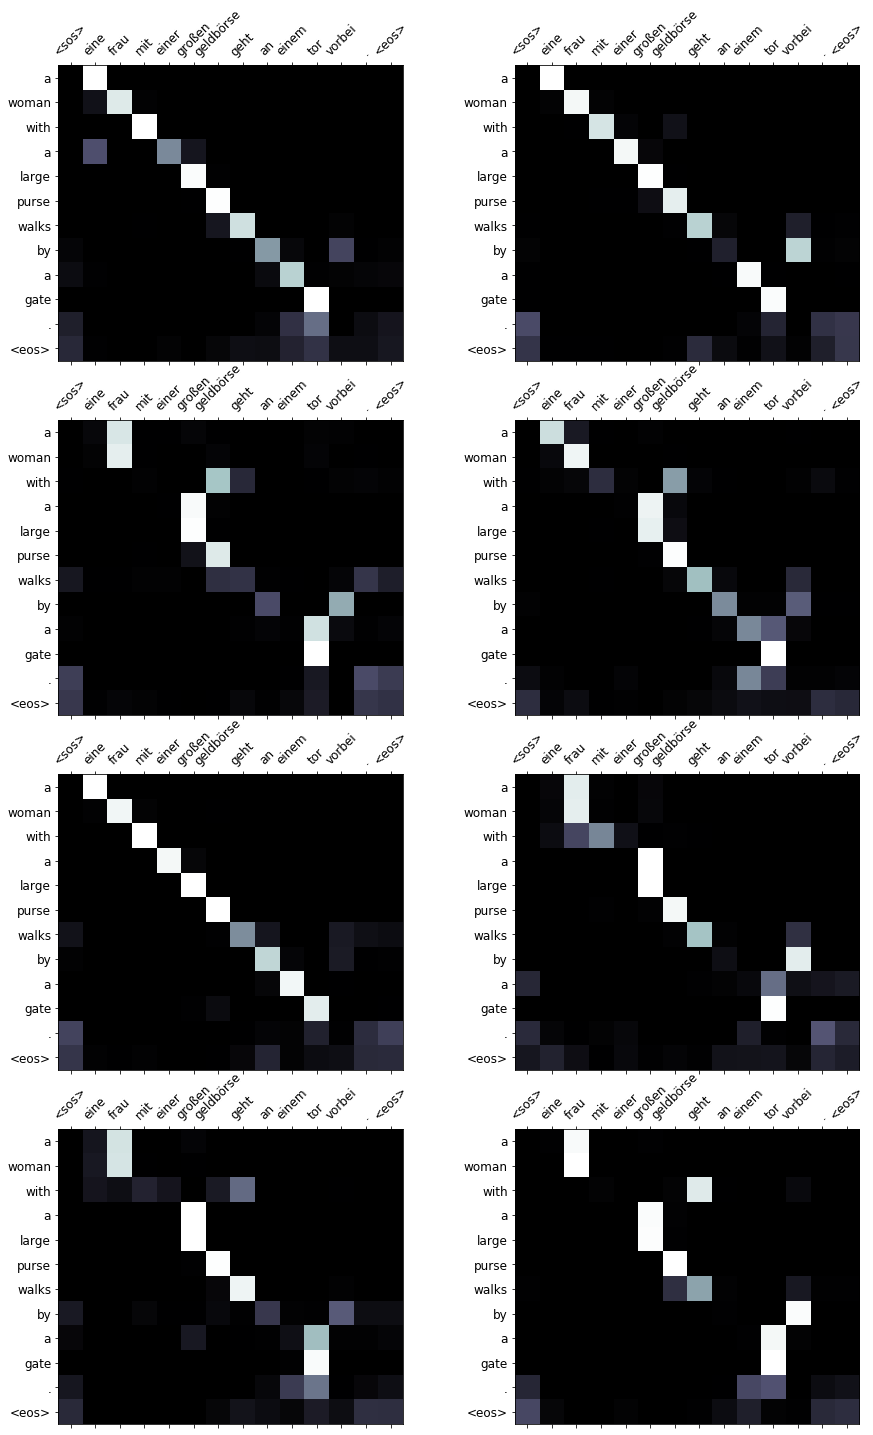

In [33]:
display_attention(src, translation, attention)

In [34]:
# example from test set

example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [35]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'Predicted trg = {translation}')

Predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoy', 'a', 'beautiful', 'day', 'outdoors', '.', '<eos>']


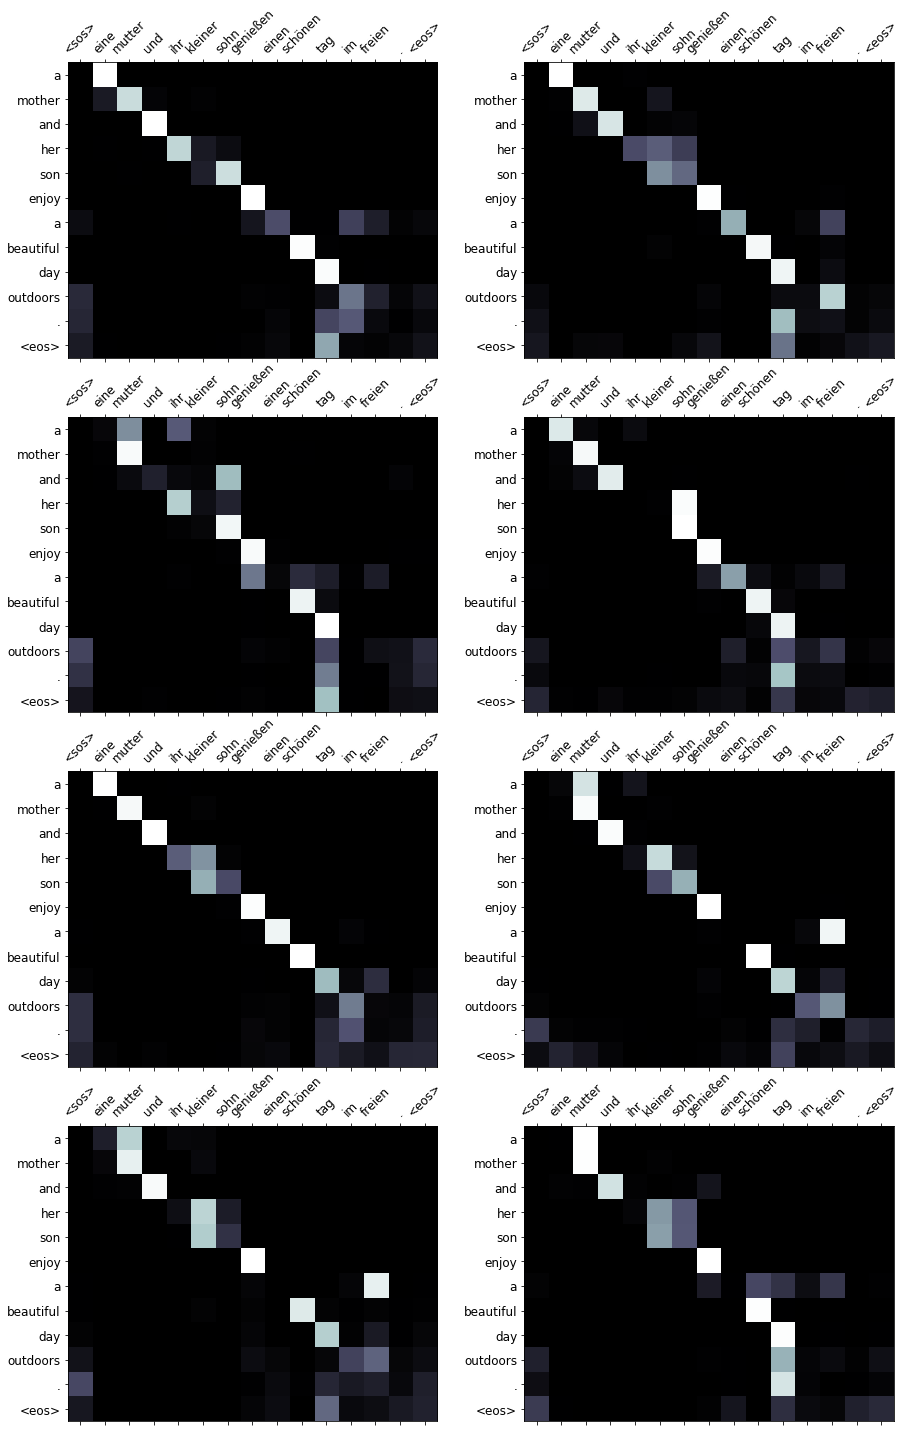

In [36]:
display_attention(src, translation, attention)

### BLEU 

calculate BLEU score

In [37]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

BLEU score of 35.53, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. 
All this whilst having the least amount of parameters and the fastest training time!

In [38]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.53
